# Tema 8: Estimación Cuántica de Fase

En este notebook vamos a implementar el algoritmo de Estimación Cuántica de Fase (Quantum Phase Estimation o QPE), uno de los algoritmos cuánticos más importantes y fundamentales. Este algoritmo nos permite estimar el valor propio (autovalor) asociado a un autovector de un operador unitario.

El problema que resuelve QPE es el siguiente: dado un operador unitario U y un autovector |ψ⟩ tal que U|ψ⟩ = e^(2πiθ)|ψ⟩, queremos estimar el valor de la fase θ. Esta capacidad es crucial porque muchos algoritmos cuánticos importantes, como el algoritmo de Shor para factorización y algoritmos de química cuántica, utilizan QPE como subrutina fundamental.

A lo largo de este notebook, exploraremos la implementación de QPE para diferentes operadores unitarios y estados cuánticos, analizando cómo la precisión de la estimación depende del número de qubits de control (qubits clock) que utilicemos.

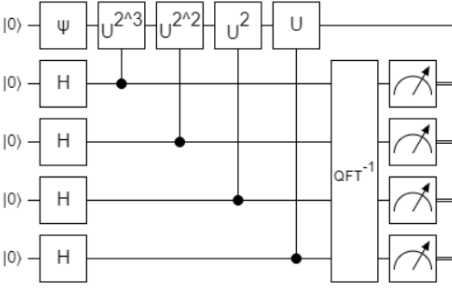

## Desarrollo Teórico
El algoritmo de Estimación Cuántica de Fase (QPE) es fundamental en computación cuántica. Su objetivo es estimar la fase θ en la relación:

$$U|\psi\rangle = e^{2\pi i\theta}|\psi\rangle$$

donde U es un operador unitario y |ψ⟩ es uno de sus autovectores.

**Estructura del algoritmo:**

1. **Registros cuánticos:**
   - m qubits "clock" (control) inicializados en |0⟩
   - n qubits para el estado |ψ⟩

2. **Pasos del algoritmo:**

   **Paso 1:** Aplicar Hadamard a todos los qubits clock:
   $$|0\rangle^{\otimes m} \xrightarrow{H^{\otimes m}} \frac{1}{\sqrt{2^m}}\sum_{j=0}^{2^m-1}|j\rangle$$

   **Paso 2:** Aplicar potencias controladas de U:
   Para cada qubit clock k (k = 0, 1, ..., m-1), aplicar $U^{2^k}$ controlado. Esto genera:
   $$\frac{1}{\sqrt{2^m}}\sum_{j=0}^{2^m-1}e^{2\pi i\theta j}|j\rangle \otimes |\psi\rangle$$

   **Paso 3:** Aplicar QFT inversa a los qubits clock:
   La QFT inversa transforma la información de fase en amplitudes medibles, produciendo:
   $$|\tilde{\theta}\rangle \otimes |\psi\rangle$$
   
   donde $\tilde{\theta}$ es la aproximación binaria de θ con m bits de precisión.

3. **Medición:** Al medir los qubits clock, obtenemos una cadena binaria que representa θ:
   $$\theta \approx \frac{\text{resultado medido}}{2^m}$$

**Precisión:** Con m qubits clock, la precisión es de $\frac{1}{2^m}$, permitiendo estimar θ con m bits de precisión.

## Librerías

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

---
# Circuito cuántico

Para el circuito cuántico tendremos que tener n qubits para el estado y m qubits clock para los autovalores (que definirán el tamaño de la QFT inversa). También tendremos como entrada el operador unitario. La salida será la puerta de la QPE.

Para ahorrar tiempo, utilizaremos la QFT que tiene qiskit implementada.

Vamos a eliminar los SWAP de la QFT, por lo que cambiamos el orden de los qubits clock.

In [17]:
from qiskit.circuit.library import QFTGate

In [28]:
def QPE(n:int,m:int,unitary):
    #Registros
    qr = QuantumRegister(n, 'State')
    clock = QuantumRegister(m, 'Clock')

    #Circuito
    qc = QuantumCircuit(clock, qr, name='QPE')

    #Capa de h
    qc.h(clock)

    #Para cada qubit clock
    for i in range(m):
        qc.append(unitary.repeat(2**(i)).control(1), [clock[i]]+qr[:])


    #QFT inversa final sin los SWAPS
    for i in range(m // 2):
        qc.swap(clock[i], clock[m - 1 - i])
    qc.append(QFTGate(m).inverse(), clock[::-1])

    #Tenemos que descomponer la IQFT para evitar errores
    qc_desc = qc.decompose('IQFT', reps=1)

    #Convertimos en gate
    QPE_Gate = qc_desc.to_gate()

    return QPE_Gate

Creamos una unitaria de prueba. Por simplicidad, vamos a escoger $\mathbb{I}\otimes P(2\pi\theta) \otimes P(2\pi\theta) \otimes \mathbb{I}$

In [29]:
n = 4
theta = 0.25
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.p(2*np.pi*theta,[1,2])
unitary = unitary_circuit.to_gate()

Veamos el circuito obtenido.

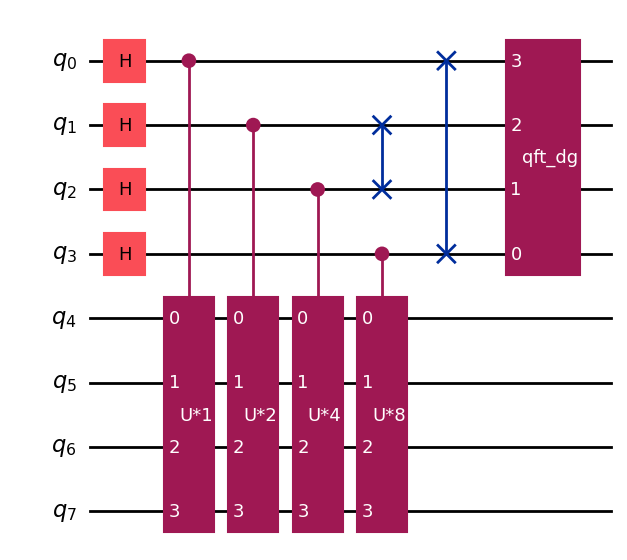

In [30]:
m = 4
qc = QuantumCircuit(n+m)
#Llamamos directamente a la puerta, sin necesidad de guardarla
qc.append(QPE(n,m,unitary), range(n+m))

#Descomponemos para ver el circuito
qc2 = qc.decompose(['QPE', 'IQFT'], reps=2)
qc2.draw('mpl')

Vamos a aplicarla sobre un estado concreto. Este será un estado de la base computacional, ya que estos son los autovectores de las P. En principio, si el qubit 1 o el 2 están en $|1\rangle$, el autovalor será $e^{i2\pi\theta}$, pero si están en $|0\rangle$ ambos será $1$, y si están en $|1\rangle$ ambos, será $e^{i2\pi 2\theta}$.

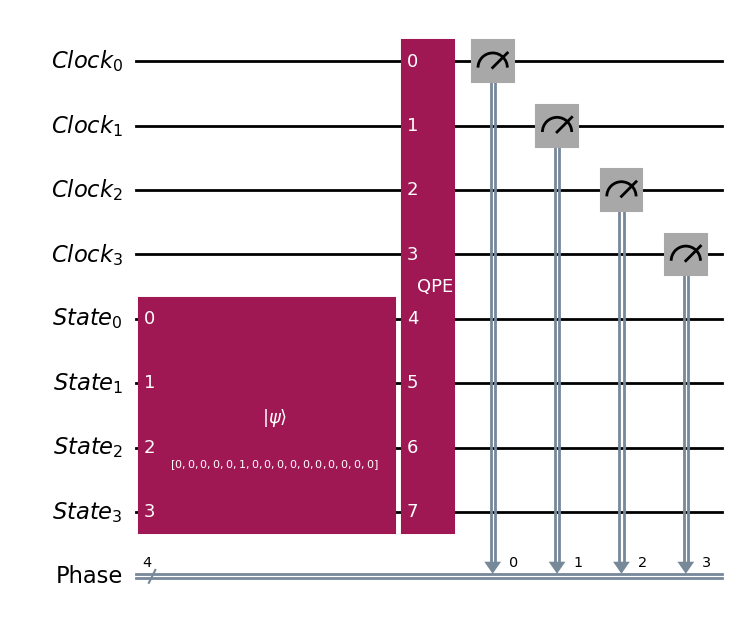

In [31]:
#Empezamos en 0 todo
state = np.zeros(2**n)
#Añadimos el elemento en 1 (Recuerda el orden de los qubits)
elem = '0101'
#Convertimos a decimal
state[int('0b'+elem,2)] = 1

#Circuito cuantico
qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)

#Aplicamos la QPE
qc.append(QPE(n,m, unitary), clock[:]+qr[:])

#Medimos los qubits clock a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)

qc.draw('mpl')

---
# Ejecutando el circuito

Ejecutamos el circuito en simulador.

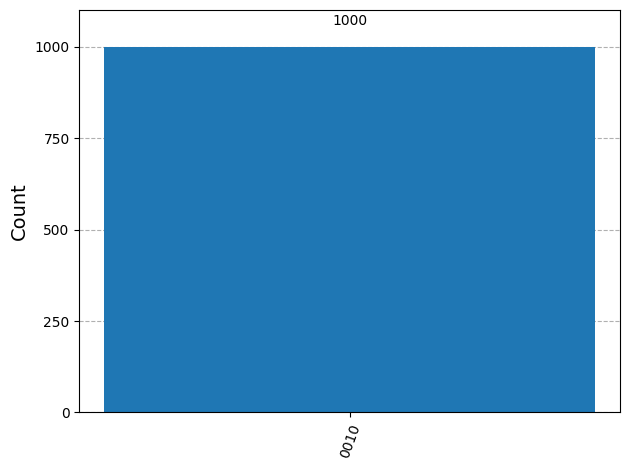

In [32]:
#Número de shots
n_shots = 1000

#Simulador de n+m qubits
backend = AerSimulator()  # n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Comprobamos qué valor de $\theta$ hemos obtenido.

In [33]:
resultado = '0010'

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)

theta =  0.25 . theta obtenido =  0.25


---
# Otras pruebas

Vamos a probar con otros estados.

theta =  0.25 . theta obtenido =  0.25


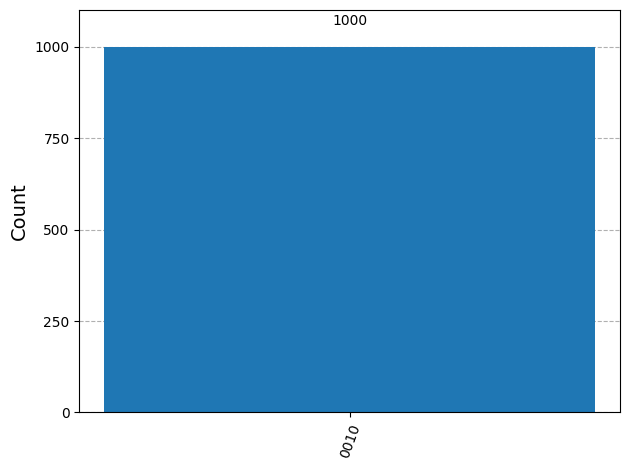

In [34]:
n = 4
theta = 0.25
m = 4
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.p(2*np.pi*theta,[1,2])
unitary = unitary_circuit.to_gate()

#Empezamos en 0 todo
state = np.zeros(2**n)
#Añadimos el elemento en 1
elem = '0101'
#Convertimos a decimal
state[int('0b'+elem,2)] = 1

qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)
qc.append(QPE(n,m,unitary),clock[:]+qr[:])

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()  # n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
resultado = max(counts, key=counts.get)

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)
#Ploteamos los histogramas de resultados
plot_histogram(counts)


theta =  0.25 . theta obtenido =  0.5


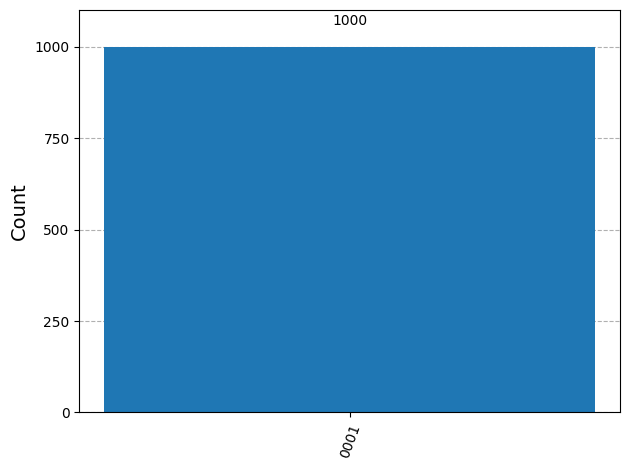

In [35]:
n = 4
theta = 0.25
m = 4
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.p(2*np.pi*theta,[1,2])
unitary = unitary_circuit.to_gate()

#Empezamos en 0 todo
state = np.zeros(2**n)
#Añadimos el elemento en 1
elem = '0110'
#Convertimos a decimal
state[int('0b'+elem,2)] = 1

qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)
qc.append(QPE(n,m,unitary),clock[:]+qr[:])

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()  # n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
resultado = max(counts, key=counts.get)

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)
#Ploteamos los histogramas de resultados
plot_histogram(counts)


En este caso tenemos el doble porque tenemos 2 veces aplicado ese theta.

---
# $\theta$ no fracción de 2

Probemos con un theta que no sea una fracción de 2.

theta =  0.3 . theta obtenido =  0.3125


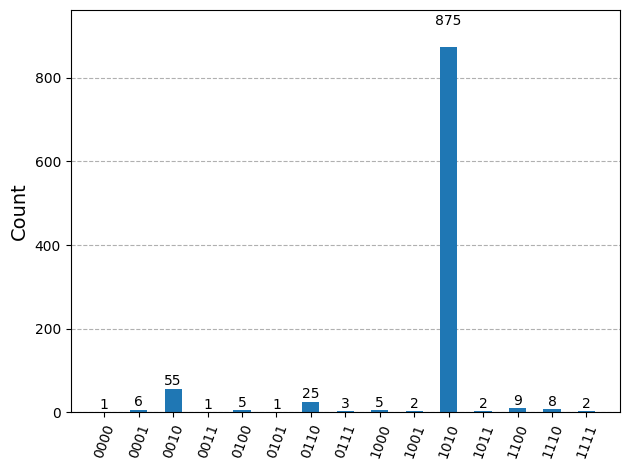

In [36]:
n = 4
theta = 0.3
m = 4
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.p(2*np.pi*theta,[1,2])
unitary = unitary_circuit.to_gate()

#Empezamos en 0 todo
state = np.zeros(2**n)
#Añadimos el elemento en 1
elem = '0101'
#Convertimos a decimal
state[int('0b'+elem,2)] = 1

qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)
qc.append(QPE(n,m,unitary),clock[:]+qr[:])

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()  # n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
resultado = max(counts, key=counts.get)

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)
#Ploteamos los histogramas de resultados
plot_histogram(counts)


Vemos que ahora hay una distribución en vez de un único pico. El máximo de la distribución coincide con el valor más próximo al valor de $\theta$. ¿Qué pasaría si aumentamos el número de qubits clock?

theta =  0.3 . theta obtenido =  0.296875


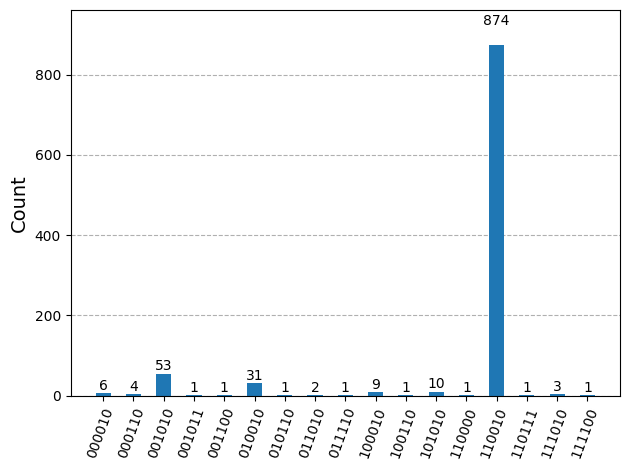

In [37]:
n = 4
theta = 0.3
m = 6
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.p(2*np.pi*theta,[1,2])
unitary = unitary_circuit.to_gate()

#Empezamos en 0 todo
state = np.zeros(2**n)
#Añadimos el elemento en 1
elem = '0101'
#Convertimos a decimal
state[int('0b'+elem,2)] = 1

qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)
qc.append(QPE(n,m,unitary),clock[:]+qr[:])

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()  # n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
resultado = max(counts, key=counts.get)

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vemos que el pico obtenido es más alto y el valor que representa es más cercano a $\theta$, por lo que al aumentar el número de qubits clock, aumentamos la precisión para obtener el autovalor.

---
# Ejercicio

El estado $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ es autovector del operador X, con autovalor 1. Haz que el operador sea HXP($2\pi\theta$)XH de un cierto ángulo  y observa el autovalor obtenido.

theta =  0.125 . theta obtenido =  0.125


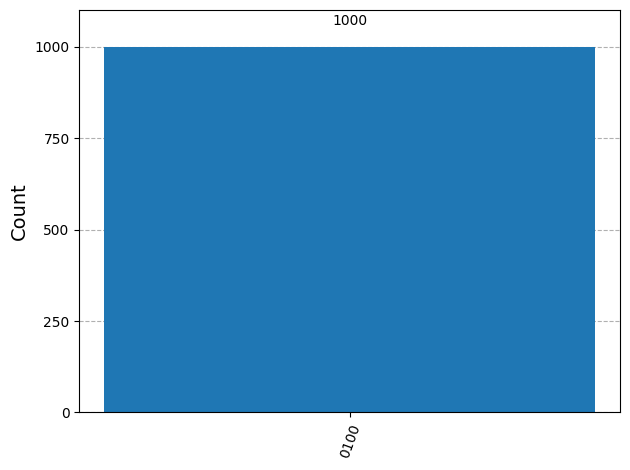

In [38]:
n = 1
theta = 0.125
m = 4
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.h(0)
unitary_circuit.x(0)
unitary_circuit.p(2*np.pi*theta,0)
unitary_circuit.x(0)
unitary_circuit.h(0)
unitary = unitary_circuit.to_gate()

#Empezamos en 1 todo
state = np.ones(2**n)

qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)
qc.append(QPE(n,m,unitary),clock[:]+qr[:])

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()  # n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
resultado = max(counts, key=counts.get)

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)
#Ploteamos los histogramas de resultados
plot_histogram(counts)

---
# Función de Qiskit

En Qiskit ya existe una función que realiza esta puerta. Esta es phase_estimation . Esta función permite indicarle:

1. Número de qubits clock: num_evaluation_qubits
2. Unitaria: unitary
3. Un nombre: name='QPE'

In [43]:
from qiskit.circuit.library import phase_estimation

theta =  0.25 . theta obtenido =  0.25


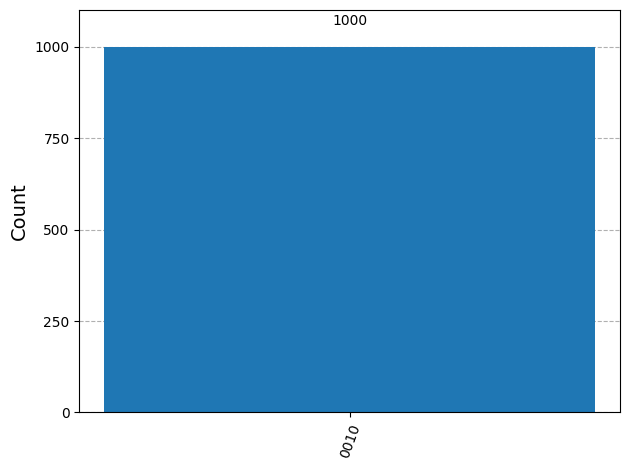

In [44]:
n = 4
theta = 0.25
m = 4
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.p(2*np.pi*theta,[1,2])
unitary = unitary_circuit.to_gate()

#Empezamos en 0 todo
state = np.zeros(2**n)
#Añadimos el elemento en 1
elem = '0101'
#Convertimos a decimal
state[int('0b'+elem,2)] = 1

qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)
qc.append(phase_estimation(m,unitary),clock[:]+qr[:])

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()  # n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)
resultado = max(counts, key=counts.get)

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)
#Ploteamos los histogramas de resultados
plot_histogram(counts)